# Agrupación de géneros musicales

### Daniel Marín López
---

### Importamos librerías

In [1]:
!pip install kneed

In [2]:
import kagglehub
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [3]:
Kmax = 11 # Número máximo de clusters
SEED = 42

In [4]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

In [5]:
def Elbow_BIC_iter(Kmax=10, X=None, method='elbow'):
  """
  Kmax: Número máximo de clusters
  X: Matriz de datos
  method: Método de cálculo de BIC o Elbow
  """
  results = []
  K_range = range(1, Kmax)

  for k in K_range:
      kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
      if method == 'elbow':
        kmeans.fit(X)
        results.append(kmeans.inertia_)
      elif method == 'bic':
        grupos = kmeans.fit_predict(X)
        results.append(BIC(k, grupos, X))
      else:
        raise ValueError("El método debe ser 'elbow' o 'bic'")

  if method == 'bic':
    bic_k = np.argmin(results) + 1
    return K_range, results, bic_k
  else:
    kl = KneeLocator(K_range, results, curve="convex", direction="decreasing")
    elbow_k = kl.elbow
    return K_range, results, elbow_k

---
### Ejercicio

Cada persona tiene un gusto diferente en la música. No podemos identificar qué tipo de música le gusta a una persona simplemente conociendo su estilo de vida, pasatiempos o profesión. Por lo tanto, es difícil que las aplicaciones de transmisión de música recomienden música a una persona. Pero si sabemos qué tipo de canciones escucha una persona a diario, podemos encontrar similitudes en todos los archivos de música y recomendar música similar a la persona.

Ahí es donde entra en juego el análisis de conglomerados de géneros musicales. [Aquí](https://www.kaggle.com/datasets/iamsumat/spotify-top-2000s-mega-dataset?resource=download) se os proporciona un conjunto de datos de canciones populares en Spotify, que contiene artistas y nombres de música con todas las características de audio de cada música. Su objetivo es agrupar géneros musicales en función de las similitudes en sus características de audio.

---

### 1. Carga de los datos
---

Descargamos nuestro dataset y lo cargamos.

In [14]:
!ls /kaggle/input/spotify-top-2000s-mega-dataset/

Spotify-2000.csv


In [17]:
# Download latest version
path = kagglehub.dataset_download("iamsumat/spotify-top-2000s-mega-dataset")

print("Path to dataset files:", path)

!cp /kaggle/input/spotify-top-2000s-mega-dataset/Spotify-2000.csv /content/Spotify-2000.csv

Path to dataset files: /kaggle/input/spotify-top-2000s-mega-dataset


In [18]:
data = pd.read_csv("/content/Spotify-2000.csv")
data.head()

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


Vemos que este es otro dataset con un montón de características, es muy probable que se use la PCA para visualizar los datos.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Index                   1994 non-null   int64 
 1   Title                   1994 non-null   object
 2   Artist                  1994 non-null   object
 3   Top Genre               1994 non-null   object
 4   Year                    1994 non-null   int64 
 5   Beats Per Minute (BPM)  1994 non-null   int64 
 6   Energy                  1994 non-null   int64 
 7   Danceability            1994 non-null   int64 
 8   Loudness (dB)           1994 non-null   int64 
 9   Liveness                1994 non-null   int64 
 10  Valence                 1994 non-null   int64 
 11  Length (Duration)       1994 non-null   object
 12  Acousticness            1994 non-null   int64 
 13  Speechiness             1994 non-null   int64 
 14  Popularity              1994 non-null   int64 
dtypes: i

De todas las características que tenemos, eliminamos el Índice y las características que sean cadenas de texto. Eso nos deja con un total de 9 características.

In [20]:
# Seleccionar características numéricas relevantes
features = data[[
    "Beats Per Minute (BPM)", "Energy", "Danceability",
    "Loudness (dB)", "Liveness", "Valence",
    "Acousticness", "Speechiness", "Popularity"
]]

### 2. Escalado
---

Escalamos los datos para que todos estén en la misma escala.

In [21]:
# Normalizar los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### 3. Visualización
---

Para la visualización haremos la PCA.

In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")

pd.DataFrame(np.matrix.transpose(pca.components_), columns=['PC-1', 'PC-2'], index=features.columns)

Varianza explicada por cada componente: [0.29176942 0.15970886]


,PC-1,PC-2
Beats Per Minute (BPM),0.119919,-0.311833
Energy,0.561153,-0.174282
Danceability,0.222047,0.661063
Loudness (dB),0.463232,-0.252946
Liveness,0.099783,-0.309655
Valence,0.349497,0.440946
Acousticness,-0.460417,0.140066
Speechiness,0.197239,0.046987
Popularity,0.154421,0.243421


Vemos que tenemos un 44% total de la información. Si tenemos en cuenta que hemos eliminado las características que son cadenas, eso hace que dispongamos de menos información. De nuevo, solo usamos la PCA para visualizar y nada más.

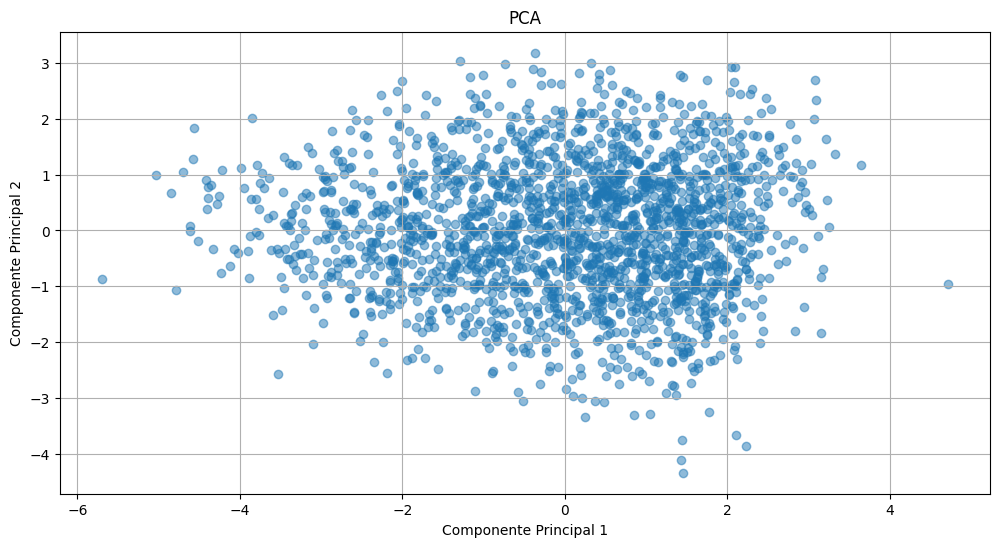

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.5)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA")
plt.grid(True)
plt.show()

Vemos que nuestros datos se agrupan en un grupo, no podría identificar más de un grupo con los datos de esta manera.

### 4. Buscar el K más óptimo
---

Volvemos a buscar el K tanto con BIC como con la suma de la distancias al cuadrado.

In [22]:
K_range, results, elbow_k = Elbow_BIC_iter(Kmax=Kmax, X=features_scaled, method='elbow')
_, bic_results, bic_elbow_k = Elbow_BIC_iter(Kmax=Kmax, X=features_scaled, method='bic')

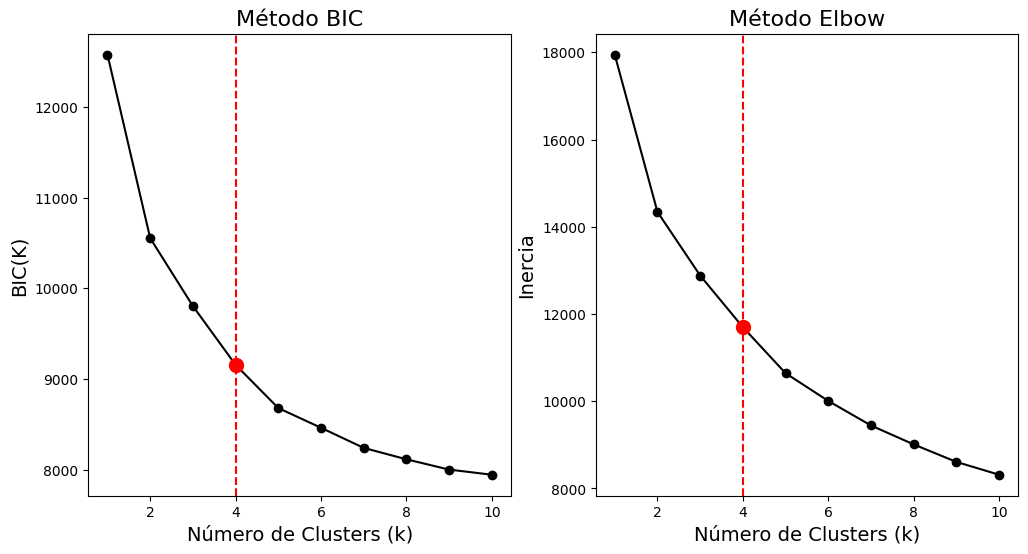

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, bic_results, "ko-")
plt.title("Método BIC", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.axvline(x=bic_elbow_k, linestyle="--", color="red", label=f'Codo en k={bic_elbow_k}')
plt.scatter(bic_elbow_k, bic_results[bic_elbow_k - 1], color='red', s=100, zorder=3)

plt.subplot(1, 2, 2)
plt.plot(K_range, results, "ko-")
plt.title("Método Elbow", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("Inercia", fontsize=14)
plt.axvline(x=elbow_k, linestyle="--", color="red", label=f'Codo en k={elbow_k}')
plt.scatter(elbow_k, results[elbow_k - 1], color='red', s=100, zorder=3)

plt.show()

Vemos que ambos vuelven a llegar al mismo K, que vuelven a ser 4 grupos.

### 5. Creación del modelo
---

Creamos y entrenamos nuestro modelo.

In [ ]:
kmeans_model = KMeans(n_clusters=elbow_k, random_state=SEED, n_init=10)
kmeans_model.fit(features_scaled)

KMeans(n_clusters=np.int64(4), n_init=10, random_state=42)

Y sacamos los gupos y los centroides.

In [ ]:
groups = kmeans_model.predict(features_scaled)
centroides = kmeans_model.cluster_centers_

print(f"BIC: {BIC(elbow_k, groups, features_scaled)}")
print(f"Inercia: {kmeans_model.inertia_}")

BIC: 9155.726203938319
Inercia: 11697.9798779386


### 6. Visualización de los resultados
---

Por último, visualizamos los resultados obtenidos.

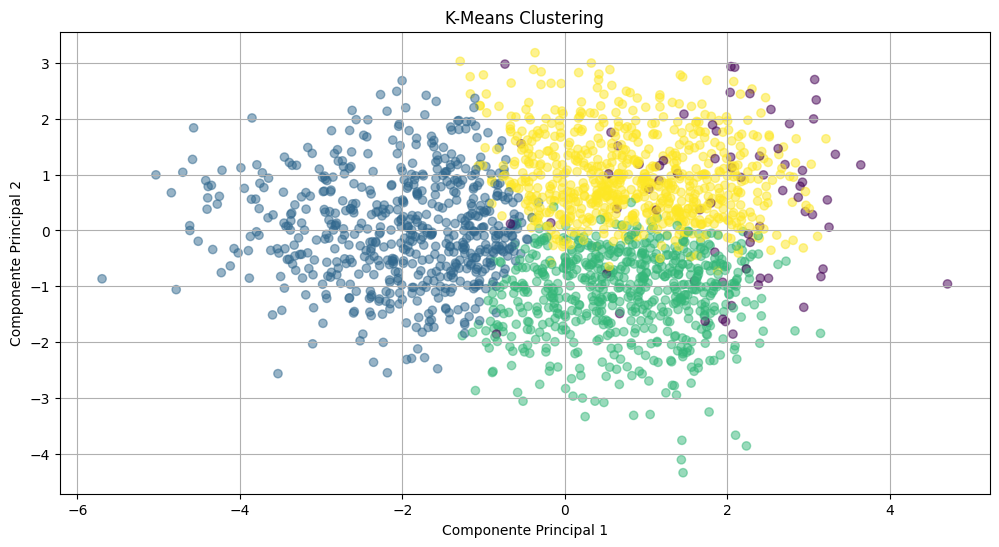

In [ ]:
plt.figure(figsize=(12, 6))
colors = plt.get_cmap("viridis", elbow_k)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=groups, cmap=colors, alpha=0.5)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("K-Means Clustering")
plt.grid(True)
plt.show()

Se puede ver que el grupo se divide en tres grupos distintos y el cuarto grupo se esparce entre los tres primeros.